## Preparation

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
# Read in the data
dat = pd.read_csv("Data/restaurant_data.csv")

In [3]:
# View the head of the data
dat.head()

,name,url,phone,address,rating,review_count,neighborhood,price_range,category,region,...,Vermouth Bars,Wine & Spirits,Wraps,Bangladeshi,Bulgarian,Champagne Bars,Iberian,Piadina,Poutineries,Shaved Snow
0,a baked joint,https://www.yelp.com/biz/a-baked-joint-washing...,(202) 408-6985,430 K St NW,4.5,1918,NaN,1.0,"['Coffee & Tea', 'Breakfast & Brunch', 'Sandwi...",Washington DC,...,0,0,0,0,0,0,0,0,0,0
1,zaytinya,https://www.yelp.com/biz/zaytinya-washington,(202) 638-0800,701 9th St NW,4.0,4687,NaN,3.0,"['Greek', 'Turkish', 'Lebanese']",Washington DC,...,0,0,0,0,0,0,0,0,0,0
2,le diplomate,https://www.yelp.com/biz/le-diplomate-washington,(202) 332-3333,1601 14th St NW,4.5,3607,Logan Circle,3.0,"['Brasseries', 'French', 'Breakfast & Brunch']",Washington DC,...,0,0,0,0,0,0,0,0,0,0
3,unconventional diner,https://www.yelp.com/biz/unconventional-diner-...,(202) 847-0122,1207 9th St NW,4.5,1166,Shaw,2.0,"['American (New)', 'Breakfast & Brunch']",Washington DC,...,0,0,0,0,0,0,0,0,0,0
4,old ebbitt grill,https://www.yelp.com/biz/old-ebbitt-grill-wash...,(202) 347-4800,675 15th St NW,4.0,8513,NaN,2.0,"['Bars', 'American (Traditional)', 'Breakfast ...",Washington DC,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Drop unnecessary columns
dat = dat.drop(columns=['name','url','phone','address','neighborhood','category'])

In [5]:
# Convert michelin_star to dummy
dat.michelin_star[dat['michelin_star'] != 0] = 1

In [6]:
# View the data type of each column
dat[['rating', 'review_count', 'price_range', 
     'region', 'michelin_star', 'michelin_guide']].dtypes

rating            float64
review_count        int64
price_range       float64
region             object
michelin_star       int64
michelin_guide      int64
dtype: object

In [7]:
dat['price_range'] = dat['price_range'].astype(int)

In [8]:
# Count NaNs in each column
dat[['rating', 'review_count', 'price_range', 
     'region', 'michelin_star', 'michelin_guide']].isna().sum()

rating            0
review_count      0
price_range       0
region            0
michelin_star     0
michelin_guide    0
dtype: int64

## Up-sample Minority Class

In [9]:
# Count of each class
dat['michelin_star'].value_counts()

0    9208
1     157
Name: michelin_star, dtype: int64

In [10]:
from sklearn.utils import resample

In [11]:
# Separate majority and minority classes
dat_majority = dat[dat.michelin_star==0]
dat_minority = dat[dat.michelin_star==1]

In [12]:
# Downsample majority class
dat_majority_downsampled = resample(dat_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=4600,   # to match minority class
                                    random_state=123) # reproducible results

In [13]:
# Upsample minority class
dat_minority_upsampled = resample(dat_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=4600,   # to match majority class
                                  random_state=123) # reproducible results

In [14]:
# Combine downsampled majority with upsampled minority
dat_sampled = pd.concat([dat_majority_downsampled, dat_minority_upsampled])

In [15]:
# Display new class counts
dat_sampled.michelin_star.value_counts()

1    4600
0    4600
Name: michelin_star, dtype: int64

## Split

In [16]:
# Split the data
y = dat_sampled[['michelin_guide']]
X = dat_sampled.drop(columns=['region','michelin_star','michelin_guide'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

## Explore Training Set

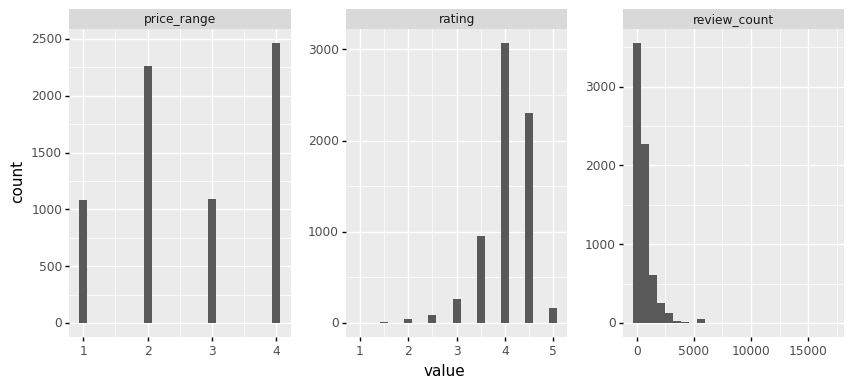

<ggplot: (296507621)>

In [17]:
# Plot the continuous variables
d = train_X[['rating', 'review_count', 'price_range']].melt()
figure1 = (
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,4),
          subplots_adjust={'wspace':0.25,'hspace':0.3})
)

figure1.save('final_report/figures/figure1.png', dpi=300, limitsize=False)
figure1

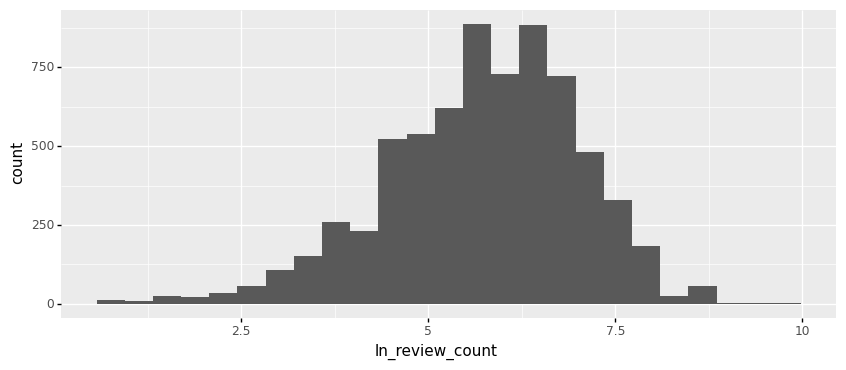

<ggplot: (296499113)>

In [18]:
# Log transform review_count
d = train_X.copy()
d['ln_review_count'] =  np.log(d['review_count'] + 1)
figure2 = (
    ggplot(d,aes(x="ln_review_count")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,4))
)

figure2.save('final_report/figures/figure2.png', dpi=300, limitsize=False)
figure2

## Pre-processing

In [19]:
# Log transform review_count
dat_sampled['review_count'] = np.log(dat_sampled['review_count'] + 1)

In [20]:
dat_sampled.columns

Index(['rating', 'review_count', 'price_range', 'region', 'michelin_star',
       'michelin_guide', 'Acai Bowls', 'Afghan', 'African', 'American (New)',
       ...
       'Vermouth Bars', 'Wine & Spirits', 'Wraps', 'Bangladeshi', 'Bulgarian',
       'Champagne Bars', 'Iberian', 'Piadina', 'Poutineries', 'Shaved Snow'],
      dtype='object', length=192)

In [21]:
# Count of each dummy
dummies = dat_sampled.columns[6:]
dum_count = dat_sampled[dummies].sum().reset_index()
dum_count.columns = ['category','count']
dum_count.sort_values(by=['count'],ascending=False)

,category,count
3,American (New),2439
85,Japanese,1321
138,Sushi Bars,992
83,Italian,791
124,Seafood,725
...,...,...
164,Cideries,0
113,Polynesian,0
173,Scottish,0
170,Nicaraguan,0


In [22]:
sum(dum_count['count'] < 300)

169

In [23]:
# Drop unnecessary dummies
dum_drop = dum_count.category[dum_count['count'] < 300].to_list()
dat_sampled = dat_sampled.drop(columns=dum_drop)

## Modeling Pipeline

In [24]:
# (0) Split the data
y = dat_sampled[['michelin_guide']]
X = dat_sampled.drop(columns=['region','michelin_star','michelin_guide'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True, random_state=202011)

# (2) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),
                       ('model',None)])

# (3) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # NaiveBayes
    {'model':[NB()]},
    
    # KNN with K tuning param
    {'model':[KNN()],
     'model__n_neighbors':[5,10,25]},
    
    # Decision Tree with the Max Depth Param
    {'model':[DT()],
     'model__max_depth':[1,3,5]},
    
    # Random forest with the N Estimators tuning param
    {'model':[RF()],
     'model__max_depth':[3,5,7,9],
     'model__n_estimators':[500,750,1000],
     'model__max_features':[3,5,7]}
]


# (4) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# (5) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [1, 3, 5]},
                         {'model': [RandomForestClassifier(max_depth=9,
                                                           max_features=7,
                                                           n_estimators=750)],
                          'model__max_depth': [3, 5, 7, 9],
                          'model__max_features': [3, 5, 7],
                          'model__n_estimators': [500, 750, 1000]}],
             scoring='roc_auc')

In [25]:
search.best_score_

0.9895638381989116

In [26]:
search.best_params_

{'model': RandomForestClassifier(max_depth=9, max_features=7, n_estimators=750),
 'model__max_depth': 9,
 'model__max_features': 7,
 'model__n_estimators': 750}

In [27]:
# Save the best model
rf_mod = search.best_estimator_

In [28]:
# AUC for the training data w/ predict_proba()
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.9953097626347411

In [29]:
# AUC for the test data w/ predict_proba()
m.roc_auc_score(test_y,rf_mod.predict_proba(test_X)[:,1])

0.984852687621971

In [30]:
# Compute the balanced accuracy for the training data
m.balanced_accuracy_score(train_y,rf_mod.predict(train_X))

0.9642219380189518

In [31]:
# Compute the balanced accuracy for the test data
m.balanced_accuracy_score(test_y,rf_mod.predict(test_X))

0.9467496542185339

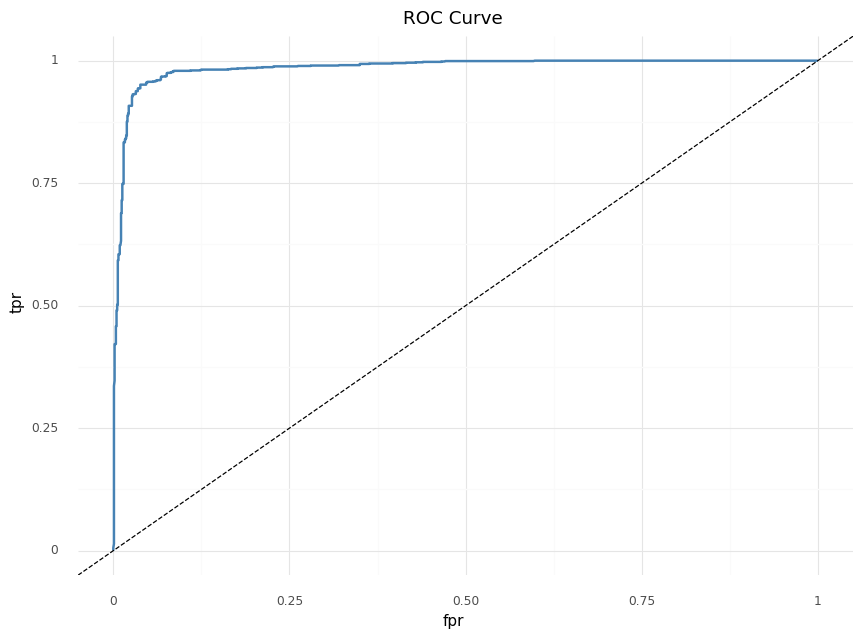

<ggplot: (296694327)>

In [39]:
# Save the predicted probabilities
probs = rf_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=rf_mod.classes_)

# Generate fpr and tpr for different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

# Plot the ROC curve
figure3 = ( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(10,7))
)

figure3.save('final_report/figures/figure3.png', dpi=300, limitsize=False)
figure3

## Variable Importance

In [33]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

In [34]:
# Permute the features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=20)

In [35]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,price_range,0.377674,0.004613,0.368449,0.386899
1,review_count,0.079051,0.002674,0.073703,0.084398
2,rating,0.063949,0.001743,0.060463,0.067436
3,American (New),0.022435,0.001212,0.020010,0.024859
4,Mexican,0.010594,0.000453,0.009687,0.011501
5,Seafood,0.007522,0.000415,0.006692,0.008351
6,American (Traditional),0.003674,0.000235,0.003204,0.004144
7,Coffee & Tea,0.003399,0.000125,0.003148,0.003649
8,Cocktail Bars,0.003377,0.000220,0.002936,0.003817
9,Chinese,0.003370,0.000078,0.003214,0.003525


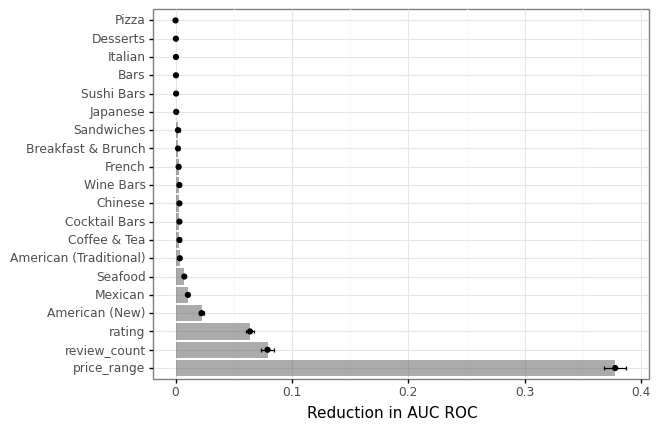

<ggplot: (297471862)>

In [40]:
# Plot
figure4 = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

figure4.save('final_report/figures/figure4.png', dpi=300, limitsize=False)
figure4

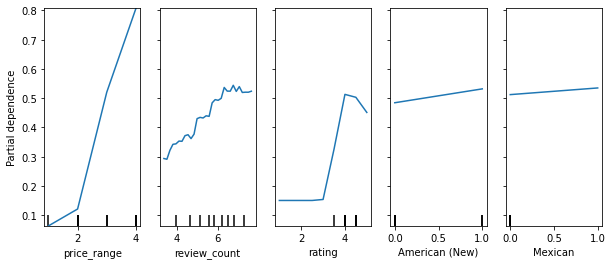

In [43]:
# Target specific features
features = ['price_range','review_count','rating',
            'American (New)','Mexican']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(10, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30, ax=ax
)

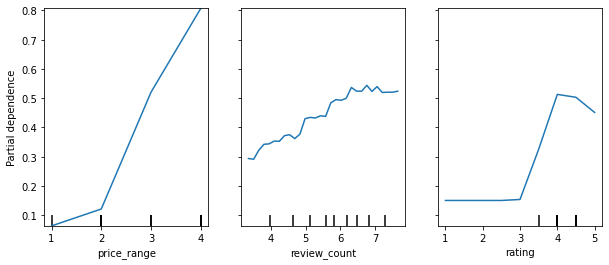

In [44]:
# Target specific features
features = ['price_range','review_count','rating']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(10, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30, ax=ax
)

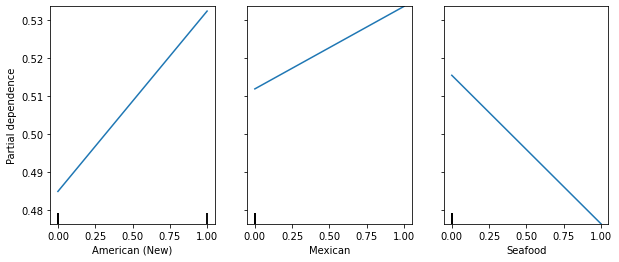

In [55]:
# Target specific features
features = ['American (New)','Mexican','Seafood']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(10, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30, ax=ax
)

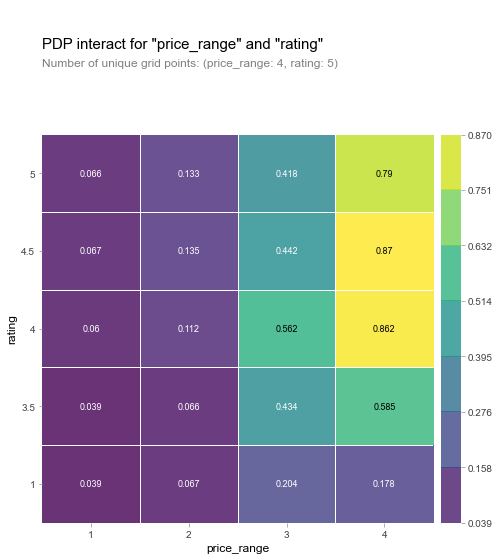

In [56]:
# Interaction Partial Dependency Plots (2D)
# for ['price_range','rating']
inter1 = pdp.pdp_interact(model = rf_mod,
                          dataset = train_X,
                          model_features = train_X.columns,
                          features=['price_range','rating'])

fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=['price_range','rating'],
                               plot_type="grid")

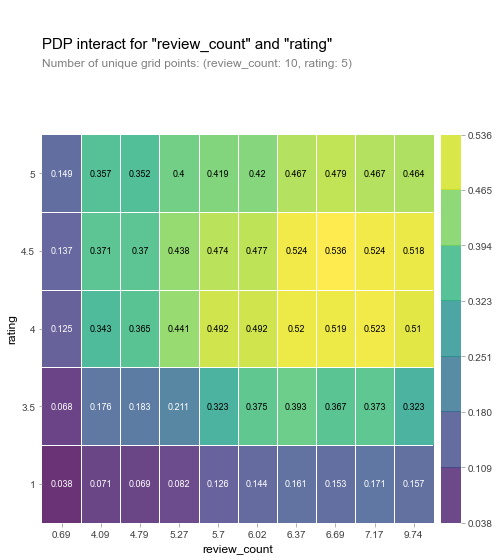

In [57]:
# Interaction Partial Dependency Plots (2D)
# for ['review_count','rating']
inter2 = pdp.pdp_interact(model = rf_mod,
                          dataset = train_X,
                          model_features = train_X.columns,
                          features=['review_count','rating'])

fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter2, 
                               feature_names=['review_count','rating'],
                               plot_type="grid")

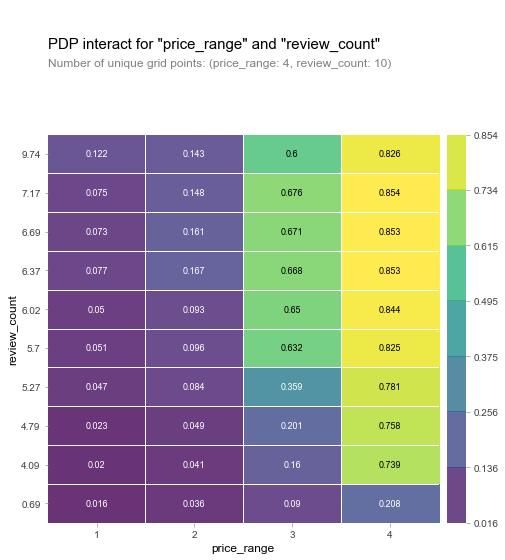

In [58]:
# Interaction Partial Dependency Plots (2D)
# for ['price_range','review_count']
inter3 = pdp.pdp_interact(model = rf_mod,
                          dataset = train_X,
                          model_features = train_X.columns,
                          features=['price_range','review_count'])

fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter3, 
                               feature_names=['price_range','review_count'],
                               plot_type="grid")

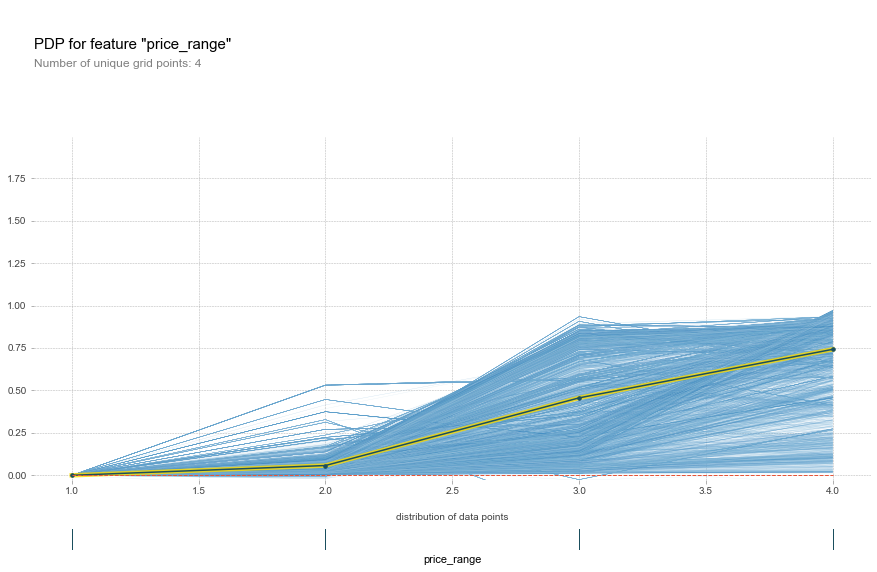

In [45]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="price_range",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'price_range',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

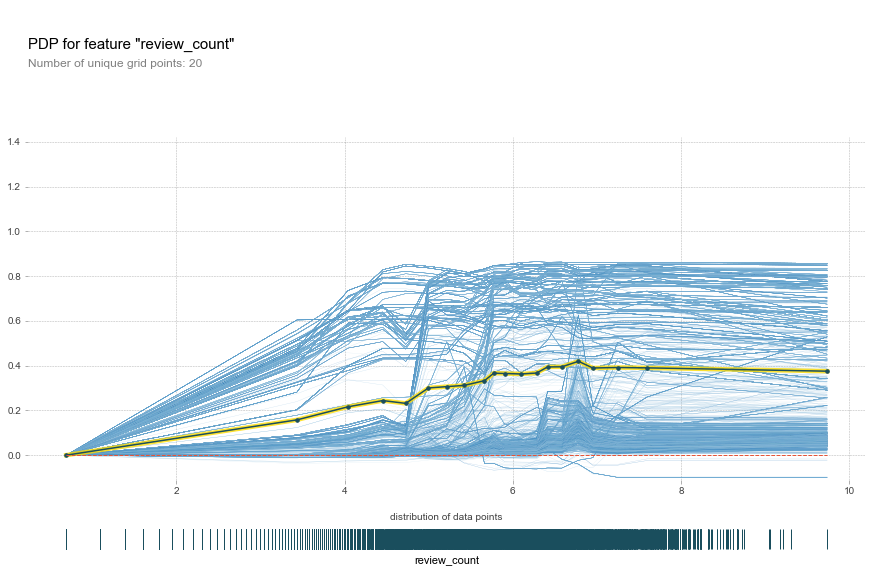

In [59]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="review_count",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'review_count',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

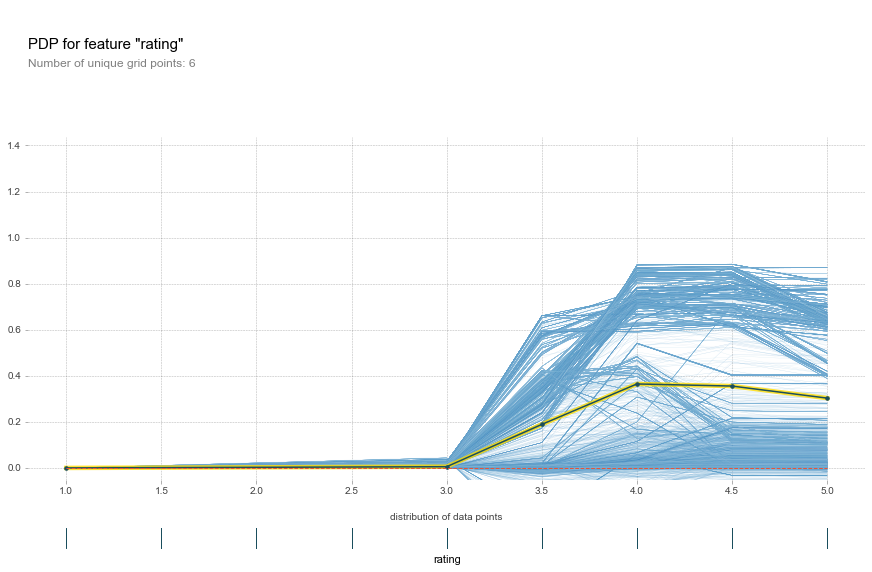

In [60]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="rating",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'rating',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))